# Entity Detecting, Matching, and Linking. 

### Authors: Albin Andersson, Salam Jonasson, Fredrik Wastring. 


Imports and define names of datafiles

In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, BertModel
import matplotlib.pyplot as plt
from tqdm import tqdm  
from typing import List,Tuple
import torch.nn as nn
import numpy as np
import regex as re
import random
import json
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
datafiles= {
  "E1" : [''],
  "E2" : ['a', 'b'],
  "E3" : [''],
  "E4" : ['']
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Headword Extraction

## Dataset Preparation 
Build the headword training set if ```SHOULD_BUILD_HEADWORD_SET``` is ```True```, toggle off this boolean if you have at least built once:

  * Use the first and second editions ([E1](./dataset/clear_text/NF_E1.txt) \& [E2](./dataset/clear_text/NF_E2a.txt)) where for each entry there is:
    - Feature: A paragraph or piece of text that starts with a headword, followed by up to <i>next_chars</i> number of characters, default is 500.
    - label: The headword at the beginning of the corresponding feature, empty string if feature wasn't a <i>"headword"</i> paragraph.

    Save results to [train_set.json](./dataset/headword/train_set.json):
    ```json
      ["Lund, uppstad i Malmöhus län...beskaffenhet. I all", "Lund"]
      ["Sammanfattningen af dessa nya ... kan man anse Brandes, hvilken", ""]
    ```

We also load in the manually annotated test set  from the json file [test_set.json](./dataset/headword/test_set.json).

In [2]:
def build_json_headword_set():
  def extract_b_tags(datastring, next_chars = 500, verbose=False):
    b_tag_dict = []

    # BUILD POSITIVE 
    for match in tqdm(re.finditer(r"((?<=<b>).+<\/b>)(.*(?<=<b>).+<\/b>)*", datastring), disable=(not verbose), desc="Positives"):
      g1 = match.group(0)
      matched_b_tag = re.sub(r"</b>.*<b>|</b>"," ",g1).strip()
      end_of_b_tag = match.end()  
      
      surrounding_text_match = re.search(r"([^<]{1,"+str(next_chars)+r"})(?=<|$)", datastring[end_of_b_tag:end_of_b_tag+next_chars])
      surrounding_text = surrounding_text_match.group(0) if surrounding_text_match else ""

      short_def = re.sub(r"\s+", " ", surrounding_text).strip()
      if len(short_def) > 0:
        b_tag_dict.append((f"{matched_b_tag} {short_def}", re.sub(r"[,.]+$", "", matched_b_tag)))

    # BUILD NEGATIVE
    for match in tqdm(re.finditer(r"(\n\n\p{Upper}[^<]{10,500})(?=\n|$|<)", datastring), disable=(not verbose), desc="Negatives"):
      g = match.group(0)
      matched_text = re.sub(r"\s+", " ", g).strip()
      b_tag_dict.append((matched_text, ""))

    return b_tag_dict

  definitions_in_test_set = [entry[0] for entry in head_test_set]
  b_tag_dict = set()

  for edition in ['E1', 'E2']:
    dataset = ""
    for file in datafiles.get(edition):
      with open(f"./dataset/clear_text/NF_{edition}{file}.txt", "r", encoding='utf-8') as fr:
        dataset += fr.read()
        fr.close()
    
    edition_b_tag = extract_b_tags(dataset, verbose=True)
    b_tag_dict.update(edition_b_tag)

    total_b_tags = len(edition_b_tag)
    nbr_headwords = len(list(filter(bool,[e[1] for e in edition_b_tag])))
    print(f"{edition} has {total_b_tags:,} entries, {nbr_headwords:,} positives and {total_b_tags-nbr_headwords:,} negatives")
  
  final_train_set = []
  for entry in tqdm(b_tag_dict, desc="Removing Test_Set entries"):
    if entry[0] not in definitions_in_test_set:
      final_train_set.append(entry)
  print(f"Found {len(b_tag_dict)-len(final_train_set)} entries already in Test_Set\nSaving only {len(final_train_set)} to train_set.json")

  with open("./dataset/headword/train_set.json", "w") as b_json:
    json.dump(final_train_set, b_json, indent=2, ensure_ascii=False)

# Load in manually annotated test set. 
def load_test_set():
  with open("./dataset/headword/test_set.json", "r", encoding='utf-8') as annotated_test:
    test_set = json.load(annotated_test)
    annotated_test.close()
  return test_set
head_test_set = load_test_set()

SHOULD_BUILD_HEADWORD_SET = False
if SHOULD_BUILD_HEADWORD_SET:
  build_json_headword_set()

Tokenize the training and test sets using KB-bert ```AutoTokenizer```. The test set is tokenized everytime, but you can choose to turn off the training set tokenization after running it once by toggling off ``` TOKENIZE_TRAIN_SET ```. 

The tokenized training set is saved to [tokenized_train_set.pth](./dataset/headword/tokenized_train_set.pth), defined by the path ``` TOKNIZED_TRAIN_SET ```

In [3]:
tokenizer = AutoTokenizer.from_pretrained("KB/bert-base-swedish-cased")

def process_data(sentence, headword):
  encoded_sentence = tokenizer(
      sentence,
      add_special_tokens=True, 
      padding='max_length',   
      max_length=100,        
      truncation=True,       
      return_tensors='pt'  
  )
  encoded_headword = tokenizer(
      headword,
      add_special_tokens=True,
      padding='max_length',
      max_length=20,           
      truncation=True,
      return_tensors='pt'
  )
  return encoded_sentence['input_ids'][0], encoded_headword['input_ids'][0]

def extract_features_labels(dataset) -> Tuple[List, List]:
  x = []
  y = []
  for entry in tqdm(dataset):
    sentence, headword = process_data(entry[0], entry[1])
    x.append(sentence)

    min_len = min(len(sentence), len(headword))
    headword_mask = np.where((sentence[:min_len] > 4) & (sentence[:min_len] == headword[:min_len]), 1, 0)
    headword_mask = np.pad(headword_mask, (0, len(sentence) - min_len), 'constant')
    
    y.append(torch.tensor(headword_mask))
  return torch.stack(x).to(device), torch.stack(y).to(device)

def build_headword_dataset(): 
  with open("./dataset/headword/train_set.json", "r", encoding='utf-8') as b_json:
    dataset  = json.load(b_json)
    b_json.close()
  temp_X, temp_y = extract_features_labels(dataset)
  torch.save((temp_X,temp_y), TOKNIZED_TRAIN_SET)
  return temp_X, temp_y

X_test, y_test = extract_features_labels(head_test_set) # <-- Use this to comapre different models. 
del head_test_set

# Either build pytorch dataset out of json, or load in saved pth file.
TOKNIZE_TRAIN_SET = False
TOKNIZED_TRAIN_SET = './dataset/headword/tokenized_train_set.pth'

if TOKNIZE_TRAIN_SET:
  X, y = build_headword_dataset()            
else:
  X, y = torch.load(TOKNIZED_TRAIN_SET, weights_only=True)

print(X.shape, y.shape, X_test.shape, y_test.shape)

100%|██████████| 5000/5000 [00:03<00:00, 1580.68it/s]


torch.Size([300675, 100]) torch.Size([300675, 100]) torch.Size([5000, 100]) torch.Size([5000, 100])


Here is an example sample in our dataset:
  - **Input Sentence**  &nbsp;&emsp;&emsp;&emsp;The extracted feature, which is a random paragraph or a definition of an article. 
  - **Tokenized Sentence** &emsp;The tokenized input up to a 100 tokens, with ``` CLS = 2 ```, ``` SEP = 3 ``` and ``` PAD = 0 ```
  - **Target Mask**   &nbsp;&emsp;&emsp;&emsp;&emsp; The expected label mask, ``` 0 ``` for ``` Out_headword ``` and ``` 1 ``` for ``` In_headword ```
  - **Target Headword**   &nbsp;&emsp;&emsp;The decoded headword, constructed by applying the output mask on the tokenized input.   

In [4]:
example_index = 0
input = X[example_index]
mask = y[example_index]
headword = X[example_index][torch.flatten(torch.nonzero(y[example_index]))]
print(f"Input Sentence: \n{tokenizer.decode(input, skip_special_tokens=True)}\n")
print(f"Tokenized Sentence: \n{input.tolist()}\n")
print(f"Target Mask: \n{mask.tolist()}\n")
print(f"Target Headword: \n{tokenizer.decode(headword, skip_special_tokens=True)}")

Input Sentence: 
Pomona. 1. Astron., en af småplaneterna. 2. Rom. myt., hos forntidens romare egentligen fruktträdens gudinna ( namnet härledt af pomum, äpple ). Hon gällde äfven som maka till Vertumnus. I Rom hade hon en särskild präst. Förnämligast dyrkades hon dock på landsbygden. Liksom Vertumnus afbildas P. ofta med trädgårdsknifven och skötet fylldt af

Tokenized Sentence: 
[2, 25576, 3929, 7, 61, 7, 5143, 1066, 7, 19, 59, 4815, 1459, 14642, 183, 7, 93, 7, 2871, 7, 13020, 7, 19, 937, 14362, 18232, 2195, 115, 2559, 34012, 148, 6728, 1452, 177, 4586, 382, 681, 49795, 4815, 1065, 42257, 49801, 19, 35708, 171, 7, 807, 5829, 400, 49808, 170, 67, 5968, 76, 6244, 16583, 1146, 164, 7, 135, 2871, 365, 295, 59, 4850, 8161, 7, 43737, 180, 26119, 35005, 439, 295, 909, 68, 13034, 7, 10141, 6244, 16583, 1146, 164, 4815, 14719, 49796, 133, 7, 1468, 66, 26072, 2061, 775, 170, 36, 5528, 11, 13215, 49795, 4815, 3]

Target Mask: 
[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Split the training set into training and validation:

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20) # <-- Use to train our model or fine-tune a model.
print("Vocab size:", tokenizer.vocab_size)

Vocab size: 50325


## Define and train model
``` HeadwordExtractor ``` class containing the ``` EncoderLSTM ``` model.

In [6]:
class HeadwordExtractor():
  def __init__(self, saved_model):
    self.embedding_dim = 128
    self.hidden_dim = 128
    self.batch_size = 32
    self.num_epochs = 3
    self.learning_rate = 0.001
    self.saved_model = saved_model
    
    self.train_loader = DataLoader(TensorDataset(X_train.long(), y_train.long()), batch_size=self.batch_size, shuffle=True)
    self.val_loader = DataLoader(TensorDataset(X_val.long(), y_val.long()), batch_size=self.batch_size, shuffle=False)

    self.model = self.EncoderLSTM(tokenizer.vocab_size, self.embedding_dim, self.hidden_dim, nbr_classes=2, num_layers=1,bidi_lstm=True).to(device)

    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
    self.criterion = nn.CrossEntropyLoss()
    print(self.model)

  class EncoderLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, nbr_classes, num_layers=1, bidi_lstm=False):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=tokenizer.pad_token_id)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidi_lstm, dropout=(0.5 if num_layers > 1 else 0))
        self.drop = nn.Dropout(0.5)
        if not bidi_lstm:
            self.fc = nn.Linear(hidden_dim, nbr_classes)
        else:
            self.fc = nn.Linear(2*hidden_dim, nbr_classes)

    def forward(self, sentence):
        embeds = self.embeddings(sentence)
        encoder_out, _ = self.encoder(embeds)
        encoder_out = nn.functional.relu(encoder_out)
        drop_out = self.drop(encoder_out)
        logits = self.fc(drop_out)
        return logits

  def train_extractor(self):
    history=[]
    for epoch in range(self.num_epochs):
        print(f"Epoch {epoch+1}/{self.num_epochs}:")
      
        self.model.train()
        train_loss = 0
        train_accuracy = 0
        temp = 0
        for input_batch, target_batch in tqdm(self.train_loader, desc = "Training"):
            outputs = self.model(input_batch)

            loss = self.criterion(outputs.view(-1,outputs.shape[-1]), target_batch.view(-1))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            train_accuracy += (torch.sum(outputs.view(-1,outputs.shape[-1]).argmax(dim=1) == target_batch.view(-1))/target_batch.view(-1).shape[0]).item()
        avg_train_loss = train_loss / len(self.train_loader)
        avg_train_acc = train_accuracy / len(self.train_loader)
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.4f}")

        self.model.eval()
        with torch.no_grad():
            val_loss = 0
            val_accuracy = 0
            for input_batch, target_batch in tqdm(self.val_loader, desc = "Validation"):
              outputs = self.model(input_batch)

              loss = self.criterion(outputs.view(-1,outputs.shape[-1]), target_batch.view(-1))
              val_loss += loss.item()
              val_accuracy += (torch.sum(outputs.view(-1,outputs.shape[-1]).argmax(dim=1) == target_batch.view(-1))/target_batch.view(-1).shape[0]).item()
        avg_val_loss = val_loss/len(self.val_loader)
        avg_val_acc = val_accuracy / len(self.val_loader)
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}\n")

        history.append((avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc))
    self.__plot_metrics(history)

  def __plot_metrics(self, history):
    train_loss, train_acc, val_loss, val_acc = tuple(zip(*history))
    epochs = range(1, len(history) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_acc, marker='o', linestyle='-', label='Train Accuracy')
    plt.plot(epochs, val_acc, marker='o', linestyle='-', label='Validation Accuracy')
    plt.title('Validation vs Train Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_loss, marker='o', linestyle='-', label='Train Loss')
    plt.plot(epochs, val_loss, marker='o', linestyle='-', label='Validation Loss')
    plt.title('Validation vs Train Loss')
    plt.legend()
    plt.show()

  def predict(self, encoded_input):
    self.model.eval()
    with torch.no_grad():
      output_mask = self.model(encoded_input).argmax(dim=-1).cpu()
      
    for entry_index, token_index in enumerate(output_mask.argmax(1)):
      while_index = token_index
      while output_mask[entry_index, while_index] == 1 and while_index > 0 and tokenizer.decode(encoded_input[entry_index, while_index]).startswith("##"):
        output_mask[entry_index, while_index-1] = 1
        while_index-=1

    return output_mask
  
  def load_model(self):
     self.model.load_state_dict(torch.load(self.saved_model, weights_only=True))
     self.model.eval()
  
  def save_model(self):
     torch.save(self.model.state_dict(), self.saved_model)

Train and save model into [headword_extractor.pth](./models/headword/headword_extractor.pth) , or load model from saved file with path ``` SAVED_MODEL ```. 

Toggle boolean ``` TRAIN_NEW_MODEL ``` to switch between methods.

In [7]:
SAVED_MODEL = "./models/headword/headword_extractor.pth"

extractor = HeadwordExtractor(saved_model=SAVED_MODEL)

TRAIN_NEW_MODEL = False
if TRAIN_NEW_MODEL:
  extractor.train_extractor()
  extractor.save_model()
else:
  extractor.load_model()

EncoderLSTM(
  (embeddings): Embedding(50325, 128, padding_idx=0)
  (encoder): LSTM(128, 128, batch_first=True, bidirectional=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


## Evaluate **HeadwordExtractor**
Split between ``` headword ``` samples and ``` none_headowrd ``` samples in the test set. 

In [8]:
test_positives = (y_test.sum(dim=1) > 0).sum().item()
test_negatives = (y_test.sum(dim=1) == 0).sum().item()
test_positives,test_negatives

(4354, 646)

Predict test set and produce, ``` accuracy_score ```, ``` classification_report ``` and ``` confusion_matrix ``` from **Scikit-learn**.

Classification Report: 
              precision    recall  f1-score   support

           0     0.9981    0.9995    0.9988    486447
           1     0.9817    0.9332    0.9568     13553

    accuracy                         0.9977    500000
   macro avg     0.9899    0.9664    0.9778    500000
weighted avg     0.9977    0.9977    0.9977    500000

Confusion Matrix:


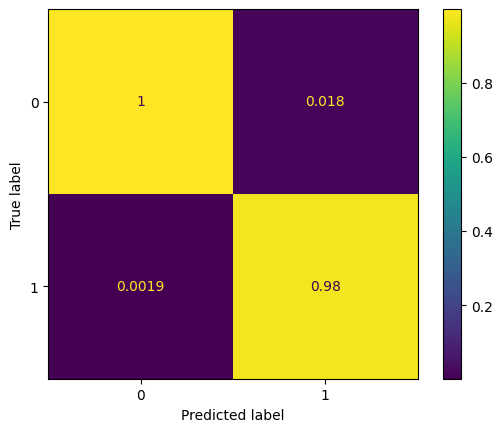

In [9]:
y_test_predictions = extractor.predict(X_test)
flattend_y_test_predictions = y_test_predictions.view(-1)
flattend_y_test = y_test.view(-1).cpu()

print(f"Classification Report: \n{classification_report(flattend_y_test, flattend_y_test_predictions, digits=4)}")
cm = confusion_matrix(flattend_y_test, flattend_y_test_predictions, normalize='pred')
cmd = ConfusionMatrixDisplay(cm, display_labels=[0,1])
cmd.plot()
print("Confusion Matrix:")

Test model in inference mode, change ``` input_sentence ``` to a *definition-like* piece of text.

In [10]:
input_sentence = "Gustav Vasa, ursprungligen Gustav Eriksson,[2] enligt flera källor född 12 maj 1496, död 29 september 1560 på Tre Kronor i Stockholm.[3] var kung av Sverige 1523–1560 och riksföreståndare 1521–1523, under det pågående befrielsekriget. Hans makttillträde, inlett som ett uppror mot unionskungen Kristian II efter Stockholms blodbad, innebar slutet för Kalmarunionen. Gustav tillhörde Vasaätten, som genom"
encoded_input = tokenizer(input_sentence, return_tensors="pt", padding = "max_length", max_length = 100, truncation = True)['input_ids'].to(device)

output_mask = extractor.predict(encoded_input).view(-1)
headword = encoded_input.cpu().view(-1)[torch.flatten(torch.nonzero(output_mask))]
decoded_headword = tokenizer.decode(headword, skip_special_tokens=True)
print("Predicted headword:", decoded_headword)

Predicted headword: Gustav Vasa


## Extract Headwords from editions

Tokenize all the editions using their txt formats and save them into a single file [tokenized_editions.pth](./dataset/clear_text/tokenized_editions.pth).

You can load in the tokenized file by toggling off the ``` SHOULD_TOKENIZE_EDITIONS ``` if you have tokenized at least once.

In [11]:
def tokenize_editions():
  tokenized_editions = []
  for edition in datafiles.keys():
    edition_data = ""
    for file in datafiles.get(edition):
      with open(f"./dataset/clear_text/NF_{edition}{file}.txt", "r", encoding='utf-8') as fr:
        edition_data += fr.read()
        fr.close()
    edition_data = re.sub(r"<b>|</b>", "", edition_data)

    splitted_paragraphs = re.split(r"\n\n", edition_data)
    filterd_paragraphs = filter(lambda p: len(p) >= 10, splitted_paragraphs)
    truncated_paragraphs = list(map(lambda p: p[:500] if len(p) > 500 else p, filterd_paragraphs))
    
    paragraphs = torch.stack(
      [tokenizer(
          p,
          add_special_tokens=True, 
          padding='max_length',   
          max_length=100,        
          truncation=True,       
          return_tensors='pt'  
        )['input_ids'][0] 
        for p in tqdm(truncated_paragraphs)
      ]).to(device) 
    tokenized_editions.append(paragraphs)
  torch.save(tokenized_editions, './dataset/clear_text/tokenized_editions.pth')
  return tokenized_editions

SHOULD_TOKENIZE_EDITIONS = False
if SHOULD_TOKENIZE_EDITIONS:
  editions = tokenize_editions()
else:
  editions = torch.load('./dataset/clear_text/tokenized_editions.pth', weights_only=True)

Use the model *``` extractor ```* defined above, to predict and decode all the toknized editions. Discarding any entries predicted as a ``` none_headword ``` and saving the headword entires into [extracted_entries.json](./dataset/extracted_entries.json).

This task can take quite a long time, therefore you can yet again toggle off ``` PREDICT_EDITIONS ``` to only load in the extracted entries from the saved json file with the path ``` PREDICTED_EDITIONS ```.

The output given is the number of headwords per edition followed by the total sum:

``` (nbr_headwords_E1, nbr_headwords_E2, nbr_headwords_E3, nbr_headwords_E4, total_headwords) ```

In [12]:
def predict_editions():
  db = {}
  for ei, edition in enumerate(editions):
    # Predict editions by batches:
    edition_loader = DataLoader(edition, batch_size=19000, shuffle=False)
    edition_predictions = torch.empty((0,100)).to(device)
    for batch in tqdm(edition_loader, desc=f"Predicting Edtion E{ei+1}"):
      batch_prediction = extractor.predict(batch).to(device)
      edition_predictions = torch.cat((edition_predictions, batch_prediction))

    # Filter away non-headword predictions:
    predicted_input = edition[torch.unique(torch.nonzero(edition_predictions)[:, 0])]
    predicted_masks = edition_predictions[torch.unique(torch.nonzero(edition_predictions)[:, 0])]
    predicted_entries = []
    entry_cnt = 0
    for input, mask in tqdm(list(zip(predicted_input,predicted_masks)), desc=f"Decoding   Edtion E{ei+1}"):
      decoded_headword = tokenizer.decode(input[mask.nonzero().flatten()], skip_special_tokens=True)
      decoded_headword = re.sub(r",", "", decoded_headword)
      if decoded_headword != "":
        decoded_input = tokenizer.decode(input, skip_special_tokens=True)

        if not re.search(r"^Bild [\diI]+", decoded_input):
          entry_cnt+=1
          predicted_entries.append({"entry_id": f"E{ei+1}_{entry_cnt}", "headword": decoded_headword, "definition": decoded_input})
          
    db[f"E{ei+1}"] = predicted_entries

  with open(PREDICTED_EDITIONS, "w") as entry_json:
    json.dump(db, entry_json, indent=2, ensure_ascii=False)
    entry_json.close()

def load_in_db():
  try:
    with open(PREDICTED_EDITIONS, "r", encoding='utf-8') as entry_json_r:
      db = json.load(entry_json_r)
      entry_json_r.close()
  except:
    db = {}
  return db

PREDICT_EDITIONS = False
PREDICTED_EDITIONS = "./dataset/extracted_entries.json"
if PREDICT_EDITIONS:
  predict_editions()

db = load_in_db()
f"{len(db['E1']):,} {len(db['E2']):,} {len(db['E3']):,} {len(db['E4']):,} {len(db['E1']) + len(db['E2']) + len(db['E3']) + len(db['E4']):,}"

'117,473 185,063 26,464 89,221 418,221'

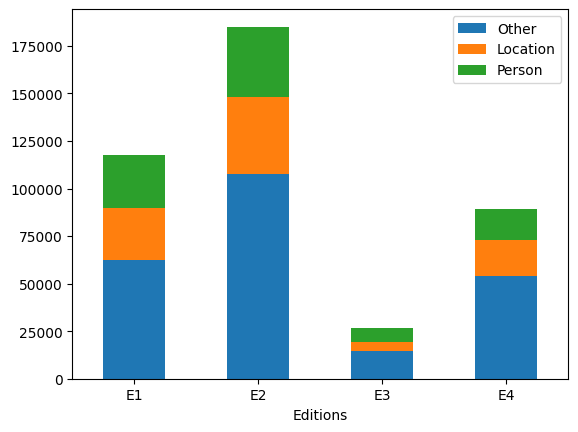

In [18]:
from collections import Counter
import pandas as pd

with open("./dataset/predicted_ner_entries.json", "r", encoding='utf-8') as ner_in:
  ner_db = json.load(ner_in)
  ner_in.close()

def plot_stacked_bar_NER(db):
  stacked_bars = pd.DataFrame([],columns=['Editions', 'Other', 'Location', 'Person'])
  for i,e in enumerate(datafiles.keys()):
    e_types = [entry['type'] for entry in db[e]]
    e_types_counter = Counter(e_types)
    stacked_bars.loc[i] = [e] + [e_types_counter[0], e_types_counter[1], e_types_counter[2]]
  stacked_bars.plot(x='Editions', kind='bar', stacked=True, rot=0)

plot_stacked_bar_NER(ner_db)

### 2 batch NER

E1 ({0: 59789, 1: 29360, 2: 28324})

E2 ({0: 105073, 1: 43010, 2: 36980})

E3 ({0: 14166, 2: 7076, 1: 5222})

E4 ({0: 52984, 1: 19639, 2: 16598})

### Ancient NER 
'E1': {0: 65622, 1: 16166, 2: 35841}

'E2': {0: 109085, 1: 22687, 2: 46677}

'E3': {0: 13980, 2: 7872, 1: 3153}

'E4': {0: 52048, 2: 19948, 1: 12171}

In [14]:
# from sentence_transformers import SentenceTransformer

# model = SentenceTransformer('KBLab/sentence-bert-swedish-cased').to(device)
# summ = 0
# for e in ner_db.keys():
#   e_entries = np.array(ner_db[e])
#   types = np.array(list(map(lambda e: e['type'],e_entries)))
#   non_other = e_entries[types != 0]

#   embeds = model.encode(list(map(lambda e: e['definition'], non_other)))
  
#   print(embeds.shape)